In [107]:
from math import exp
from random import seed
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Auxilary classes and methods

In [108]:
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [109]:
# When training, we use the binary matrix version of the labels. When evaluating 0-1 loss, we use the original label.
def transform_labels(group_set):
    new_labels = np.zeros((len(group_set), group_set.nunique()))
    for i, label in enumerate(group_set):
            new_labels[i][label-1] = 1
    return new_labels

In [110]:
def feature_minmax(df, min_value=None, minmax_gap=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if min_value is None and minmax_gap is None:
        min_value = df_normalized.min(axis=0)
        minmax_gap = df_normalized.max(axis=0) - df_normalized.min(axis=0)
    df_normalized = (df_normalized - min_value) / minmax_gap
    return df_normalized, min_value, minmax_gap

# Data importation

In [111]:
# This is a short version of the original mnist dataset. For the labels, 1-9 means the digits 1-9, but 10 refers to the digit 0.
Y = pd.read_csv('digits_labels.csv', header=None)
X = pd.read_csv('digits_data.csv', header=None)
Y.columns = ['labels']
data = pd.concat([X, Y], axis = 1)

# Train-test split

In [112]:
# Ramdomly split the data into test and train, but keep digits balanced in each
k = 9
train_set = pd.DataFrame()
test_set = pd.DataFrame()
for i in range(k+1):
    data_temp = data[data['labels']==i+1]
    train_temp, test_temp = train_test_split(data_temp, 0.2)
    train_set = pd.concat([train_set, train_temp], axis = 0)
    test_set = pd.concat([test_set, test_temp], axis = 0)

In [113]:
X_train = train_set.iloc[:, :-1]
Y_train = train_set.iloc[:, -1]
X_test = test_set.iloc[:, :-1]
Y_test = test_set.iloc[:, -1]

In [114]:
Y_train_transformed = transform_labels(Y_train)
Y_test_transformed = transform_labels(Y_test)

n = X_train.shape[0] # sample size
d = X_train.shape[1] # number of features
k = Y_train.nunique() # number of classes

input_no = d
output_no = k

# Neural network classification

In [146]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis = 1).reshape(-1, 1)

def sigmoid_derivative(x):
    return np.exp(-x) / ((1 + np.exp(-x)) ** 2)

def forward_propagation(X, W1, W2, b1, b2):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y_pred = softmax(a2)
    return a1, z1, a2, y_pred

def compute_cost(y, y_pred):
    J = 0.5 * sum((y - y_pred) ** 2)
    return J

def backward_propagation(X, y, y_pred, z2, a1, W2, z1):
    delta2 = np.multiply(-(y - y_pred), sigmoid_derivative(z2))
    dJ_dW2 = np.dot(a1.T, delta2)
    delta1 = np.dot(delta2, W2.T) * sigmoid_derivative(z1)
    dJ_dW1 = np.dot(X.T, delta1)
    return dJ_dW1, dJ_dW2

class NeuralNetwork():
    def __init__(self):
        self.W1 = None
        self.W2 = None
        self.b1 = None
        self.b2 = None
    
    def fit(self, X, y, alpha = 0.001, num_iterations = 100, lambda_ = 0.01, input_no = 400, output_no = 10, hidden_no = 10):
        #X, self.min_value, self.minmax_gap = feature_minmax(X)
        X = np.array(X)
        y = np.array(y)
        
        W1 = np.random.randn(input_no, hidden_no)
        b1 = np.ones([1, hidden_no])

        W2 = np.random.randn(hidden_no, output_no)
        b2 = np.ones([1, output_no])
        
        for i in range(num_iterations):
            z1, a1, z2, y_pred = forward_propagation(X, W1, W2, b1, b2)
            dJ_dW1, dJ_dW2 = backward_propagation(X, y, y_pred, z2, a1, W2, z1)

            W1 = W1 - (alpha * (dJ_dW1 + lambda_ * np.sign(W1))) #l1 penalty
            W2 = W2 - (alpha * (dJ_dW2 + lambda_ * np.sign(W2)))
            
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2
        
        return self

    def predict(self, X):
        #X = feature_minmax(X, self.min_value, self.minmax_gap)[0]
        y_prob = forward_propagation(X, self.W1, self.W2, self.b1, self.b2)[3]
        max_prob_ind = np.argmax(y_prob, axis = 1)
        #y_class = np.array([labels[i] for i in max_prob_ind])
        
        return y_prob, max_prob_ind + 1 # +1 to account for the zero indexing so that this term corresponds to y_train

# Tune l1 penalty strength by cross validation

In [147]:
import math

features_set = pd.DataFrame(X_train)
group_set_transformed = pd.DataFrame(Y_train_transformed)
group_set = pd.DataFrame(Y_train)

n_train = X_train.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []

meshgrid = np.arange(0, 0.1, 0.01)

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold_transformed = group_set_transformed.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold_transformed = group_set_transformed.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        nn = NeuralNetwork().fit(features_set_train_fold, group_set_train_fold_transformed, alpha = 0.001, num_iterations = 100, input_no = 400, output_no = 10, lambda_ = lambda_)
        group_set_pred = nn.predict(features_set_fold)[1]
        total_error += np.sum(group_set_pred != np.array(group_set_fold))
        #total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.01


# Apply the neural network obtained

There is a serious overfit problem seen above. If we choose num_iterations = 1000, there is a very low in sample error, but all digits will be wrongly classified out of sample. For the cross validation to yield reasonable results, I have to lower the number of iterations and the learning rate. But of course, this increases the in sample error. It might be better if I can use the original complete MNIST dataset with a much larger sample size.

Moreover, I find that the result below relies to a large extent to the intial weight and bias matrices. Even with the same hyperparameters, I obtain vastly different scores every time. Therefore it might be helpful to try different initial values and find out the best ones.

In [153]:
nn = NeuralNetwork().fit(X_train, Y_train_transformed, alpha = 0.001, num_iterations = 100, input_no = 400, output_no = 10, lambda_ = best_lambda)

In [154]:
# In sample error
Y_train_pred = nn.predict(X_train)[1]
np.sum(Y_train_pred != np.array(Y_train))

2695

In [155]:
# Test error
Y_test_pred = nn.predict(X_test)[1]
np.sum(Y_test_pred != np.array(Y_test))

696

# Misclassification matrix

Create a confusion matrix whose (i,j)th component denotes the percentage of times in which the classifier sends the figure with label i to the class j.

## Confusion matrix for the train sample

In [156]:
confusion_matrix_train = np.empty((k, k))
for i in range(k):
    for j in range(k):
        confusion_matrix_train[i, j] = np.sum((Y_train == i+1) * (Y_train_pred == j+1)) / np.sum(Y_train == i+1)

In [157]:
confusion_matrix_train

array([[0.085 , 0.02  , 0.005 , 0.0125, 0.015 , 0.04  , 0.04  , 0.2575,
        0.525 , 0.    ],
       [0.0325, 0.4475, 0.0725, 0.0575, 0.0175, 0.1175, 0.0175, 0.1375,
        0.0825, 0.0175],
       [0.0275, 0.335 , 0.33  , 0.105 , 0.065 , 0.015 , 0.005 , 0.0475,
        0.055 , 0.015 ],
       [0.    , 0.1425, 0.0375, 0.2525, 0.045 , 0.0125, 0.2225, 0.02  ,
        0.2675, 0.    ],
       [0.0175, 0.31  , 0.06  , 0.0825, 0.2975, 0.025 , 0.0475, 0.0425,
        0.0075, 0.11  ],
       [0.0075, 0.3775, 0.02  , 0.0475, 0.0525, 0.3175, 0.0525, 0.0475,
        0.0575, 0.02  ],
       [0.005 , 0.0225, 0.015 , 0.0875, 0.0375, 0.0625, 0.1725, 0.035 ,
        0.56  , 0.0025],
       [0.015 , 0.25  , 0.0275, 0.1175, 0.035 , 0.0475, 0.0425, 0.42  ,
        0.0425, 0.0025],
       [0.0075, 0.135 , 0.0475, 0.125 , 0.03  , 0.0425, 0.1825, 0.0325,
        0.395 , 0.0025],
       [0.01  , 0.175 , 0.    , 0.0025, 0.095 , 0.015 , 0.1575, 0.    ,
        0.    , 0.545 ]])

## Confusion matrix for the test sample

In [158]:
confusion_matrix_test = np.empty((k, k))
for i in range(k):
    for j in range(k):
        confusion_matrix_test[i, j] = np.sum((Y_train == i+1) * (Y_train_pred == j+1)) / np.sum(Y_train == i+1)

In [159]:
confusion_matrix_test

array([[0.085 , 0.02  , 0.005 , 0.0125, 0.015 , 0.04  , 0.04  , 0.2575,
        0.525 , 0.    ],
       [0.0325, 0.4475, 0.0725, 0.0575, 0.0175, 0.1175, 0.0175, 0.1375,
        0.0825, 0.0175],
       [0.0275, 0.335 , 0.33  , 0.105 , 0.065 , 0.015 , 0.005 , 0.0475,
        0.055 , 0.015 ],
       [0.    , 0.1425, 0.0375, 0.2525, 0.045 , 0.0125, 0.2225, 0.02  ,
        0.2675, 0.    ],
       [0.0175, 0.31  , 0.06  , 0.0825, 0.2975, 0.025 , 0.0475, 0.0425,
        0.0075, 0.11  ],
       [0.0075, 0.3775, 0.02  , 0.0475, 0.0525, 0.3175, 0.0525, 0.0475,
        0.0575, 0.02  ],
       [0.005 , 0.0225, 0.015 , 0.0875, 0.0375, 0.0625, 0.1725, 0.035 ,
        0.56  , 0.0025],
       [0.015 , 0.25  , 0.0275, 0.1175, 0.035 , 0.0475, 0.0425, 0.42  ,
        0.0425, 0.0025],
       [0.0075, 0.135 , 0.0475, 0.125 , 0.03  , 0.0425, 0.1825, 0.0325,
        0.395 , 0.0025],
       [0.01  , 0.175 , 0.    , 0.0025, 0.095 , 0.015 , 0.1575, 0.    ,
        0.    , 0.545 ]])

# Visualize misclassified data

We try to find out which digits are most frequently classified by looking at the heatmap. First, the confusion matrix for the train set.

<AxesSubplot:>

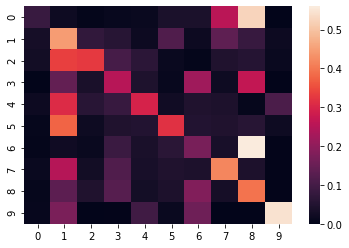

In [160]:
sns.heatmap(confusion_matrix_train)

The digit "7" is often misclassifed as "9". I will display those images.

In [161]:
misclassified_index = np.where((Y_train == 7) * (Y_train_pred == 9) == True)[0]

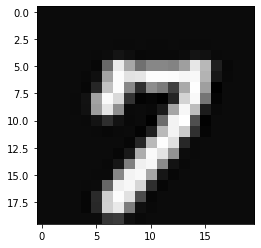

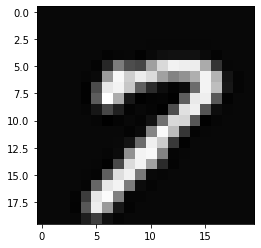

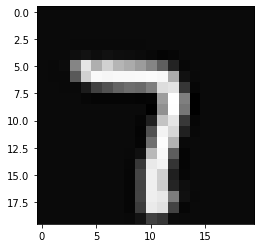

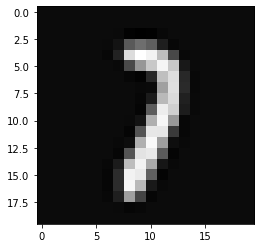

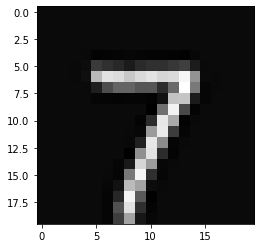

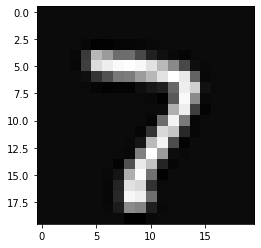

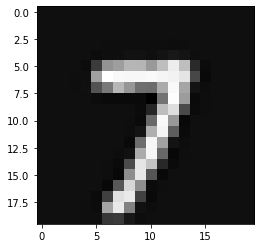

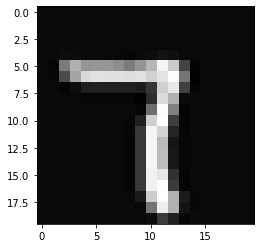

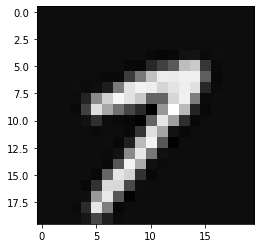

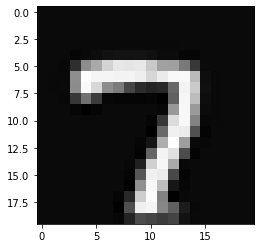

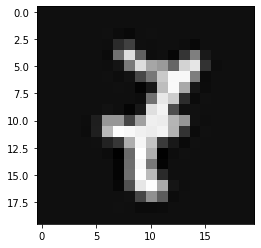

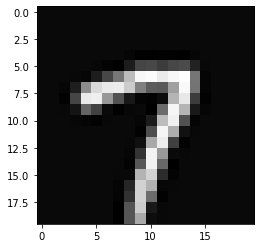

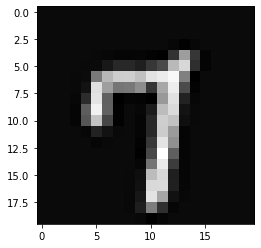

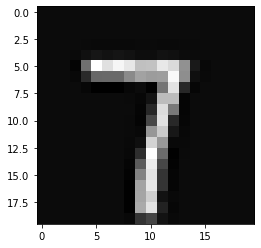

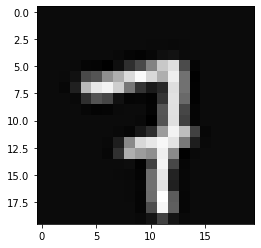

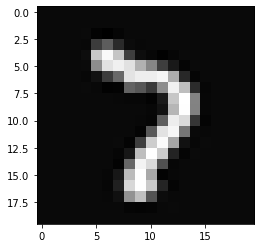

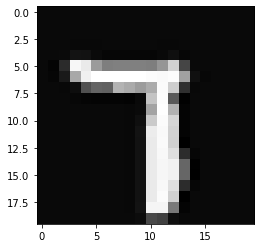

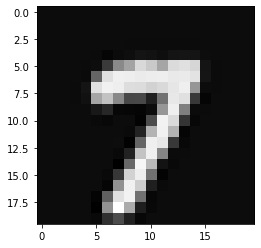

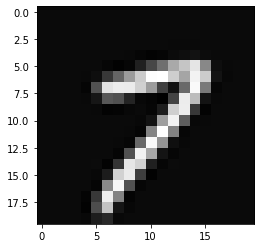

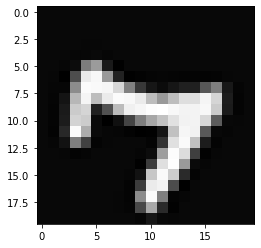

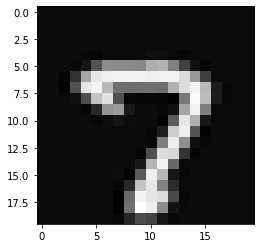

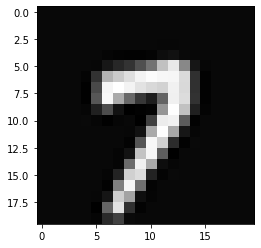

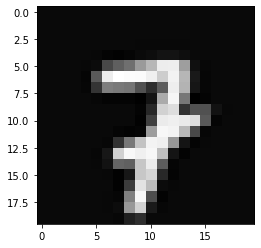

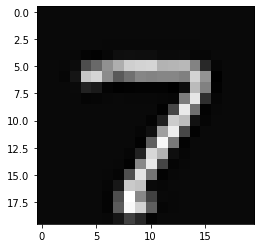

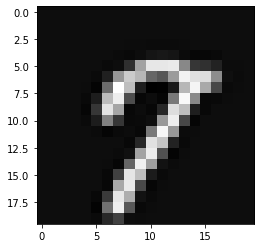

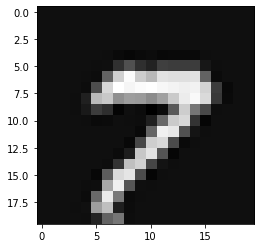

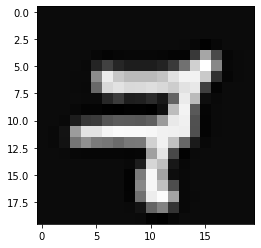

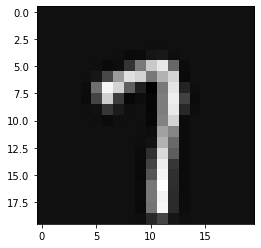

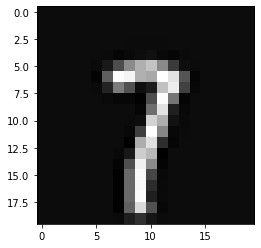

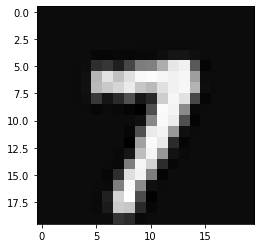

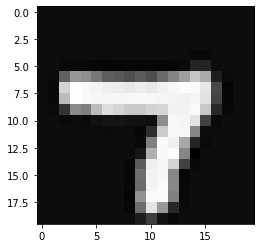

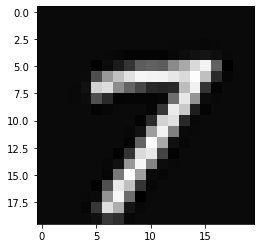

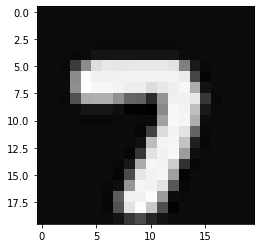

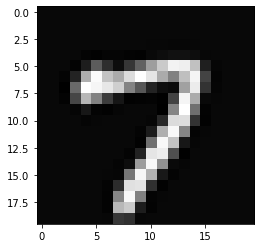

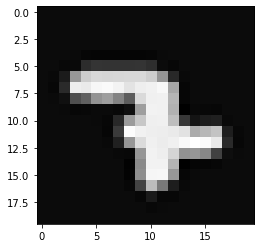

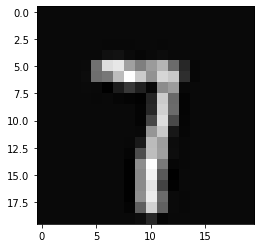

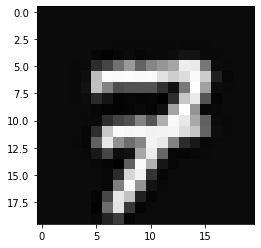

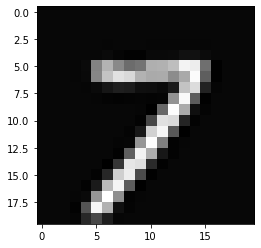

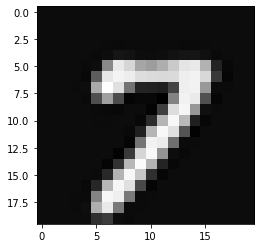

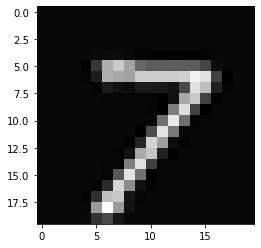

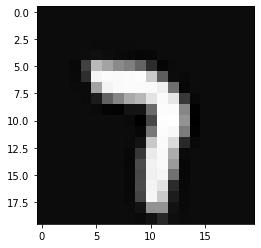

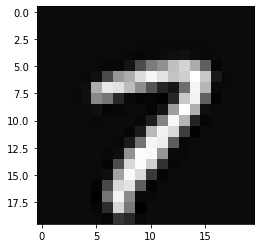

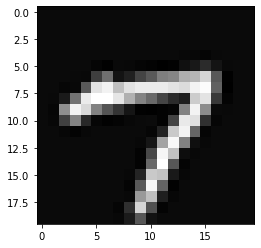

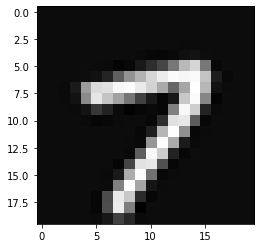

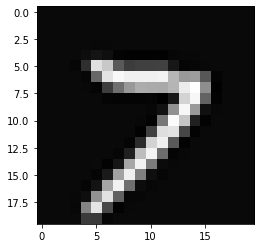

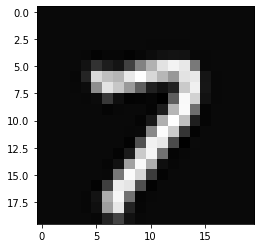

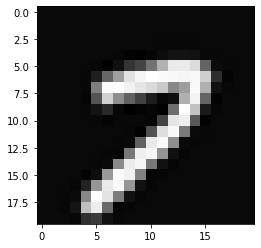

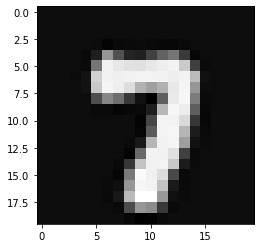

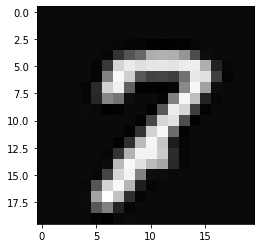

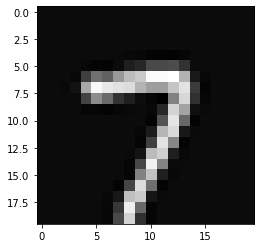

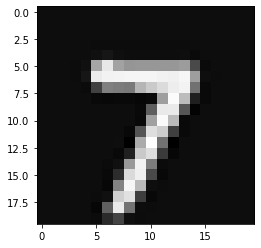

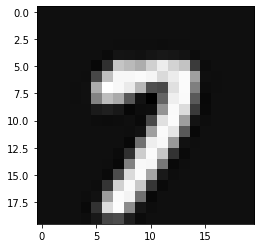

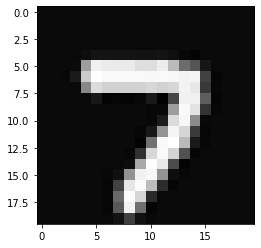

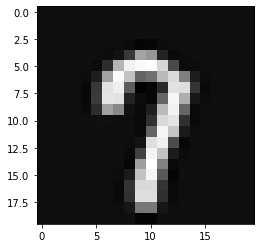

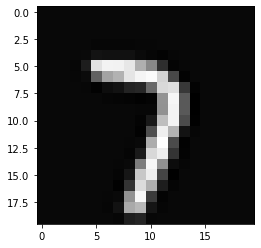

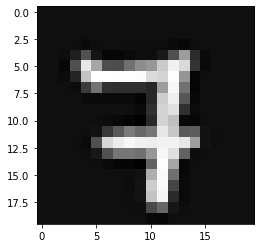

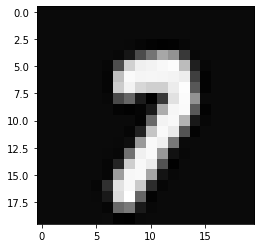

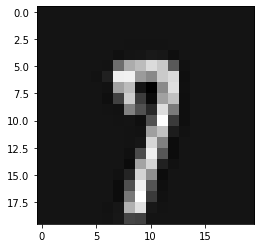

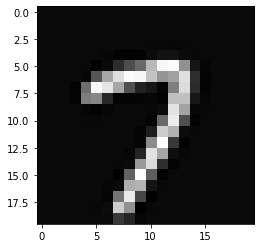

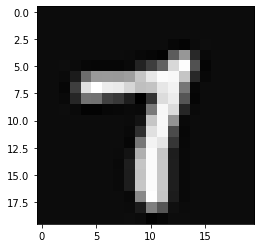

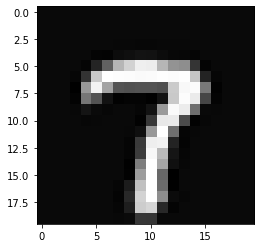

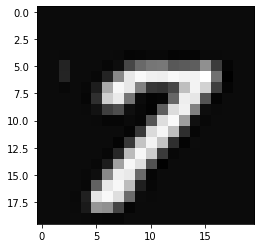

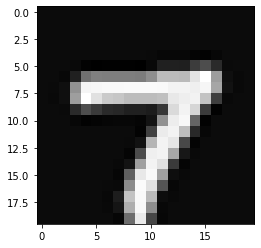

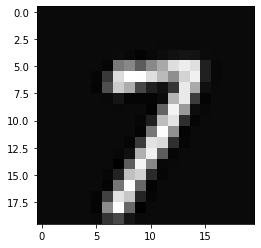

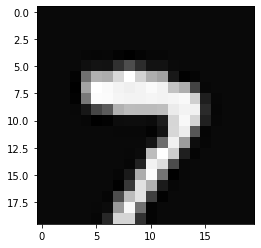

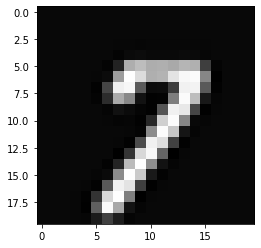

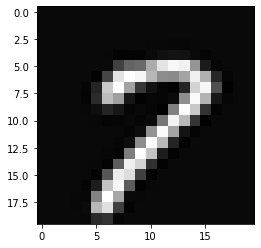

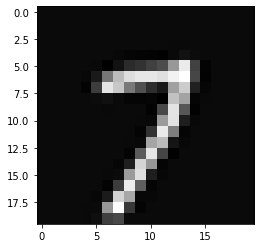

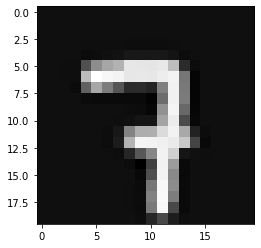

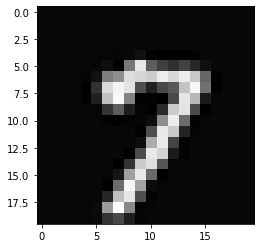

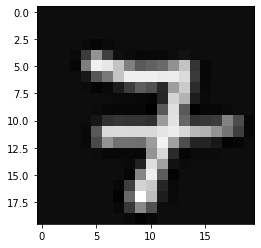

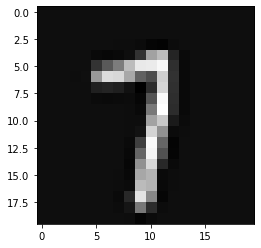

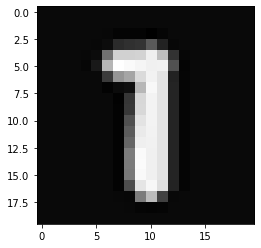

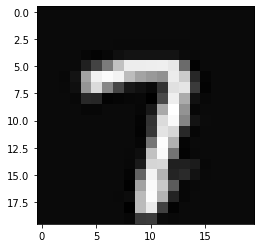

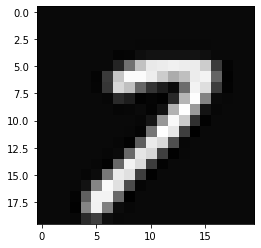

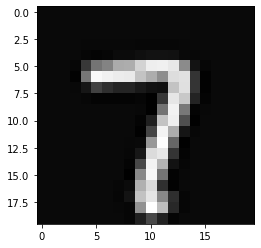

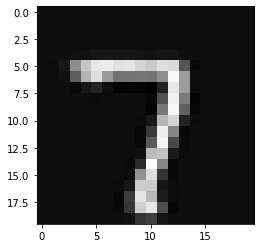

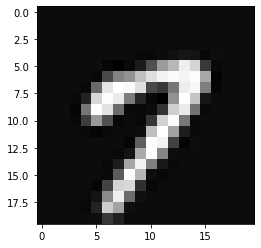

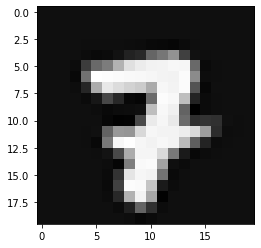

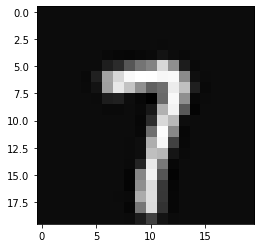

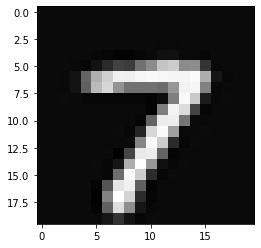

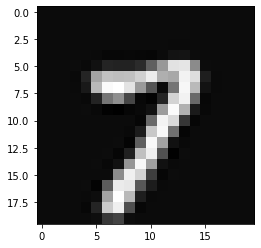

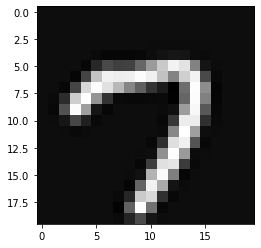

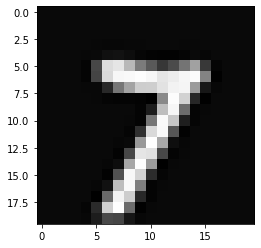

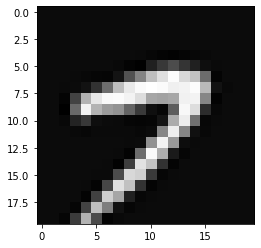

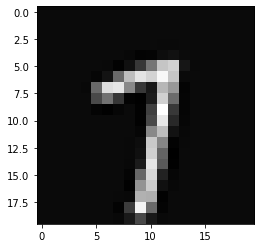

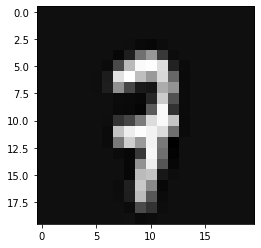

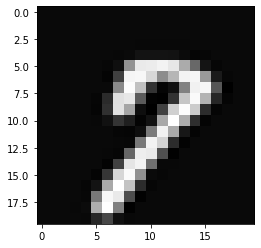

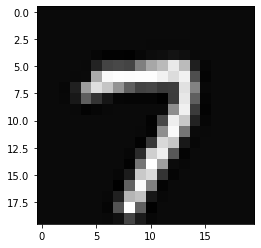

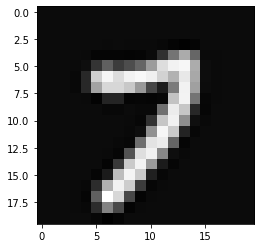

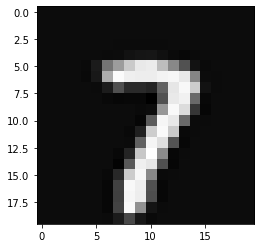

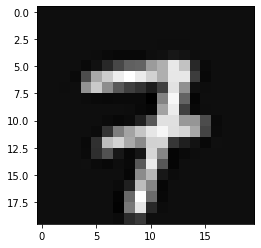

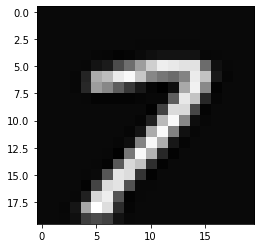

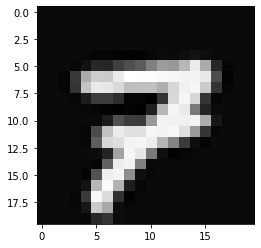

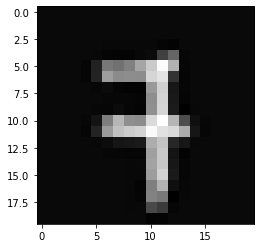

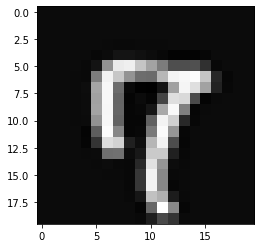

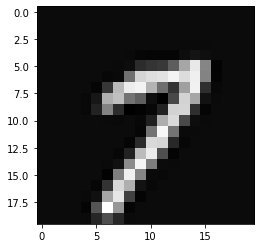

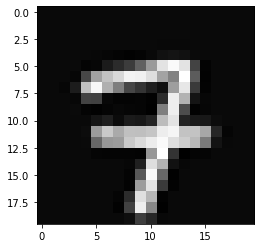

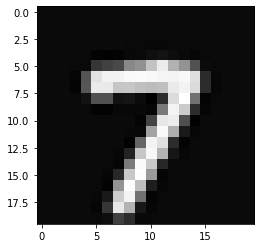

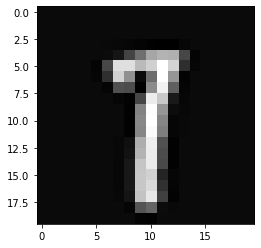

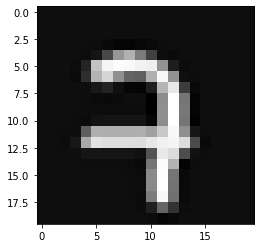

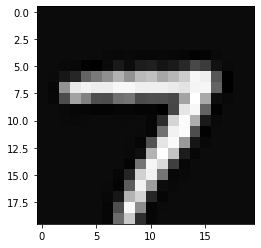

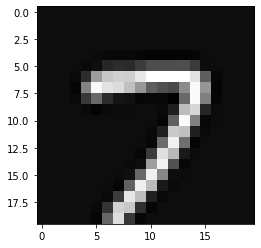

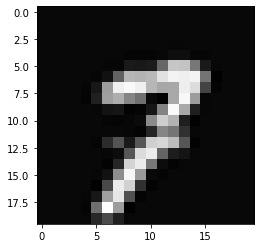

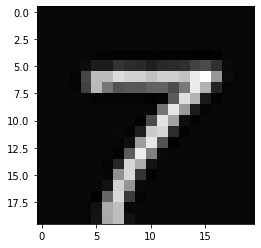

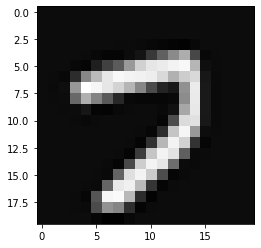

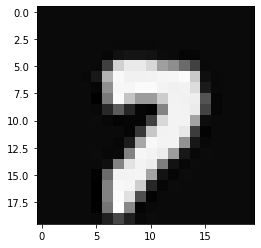

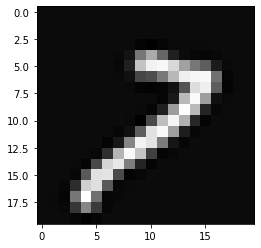

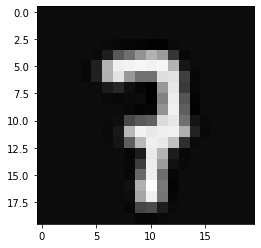

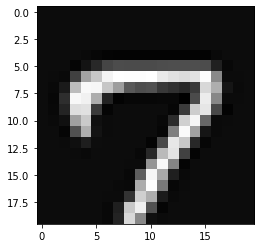

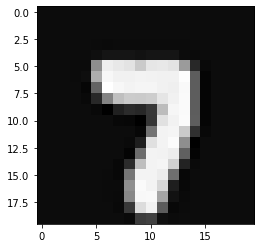

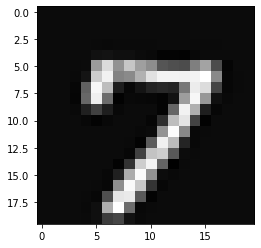

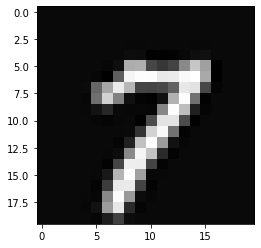

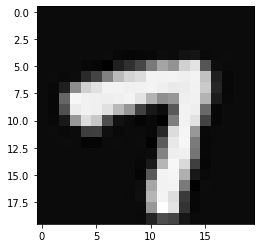

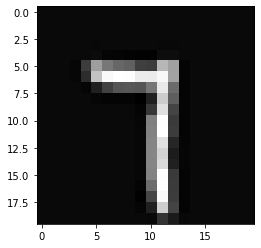

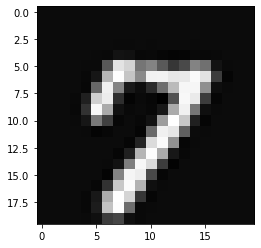

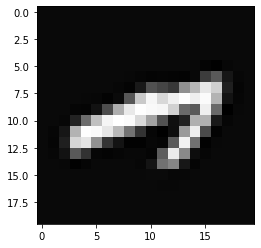

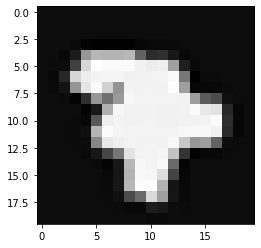

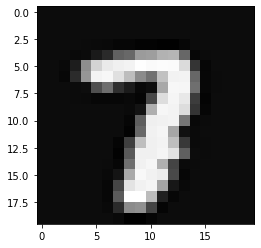

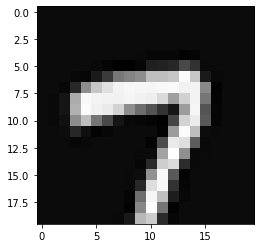

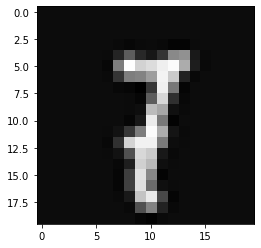

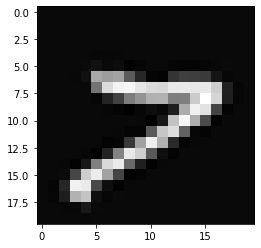

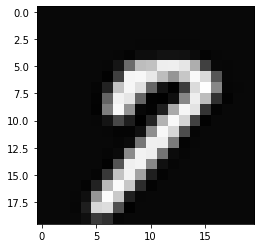

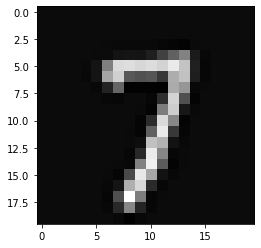

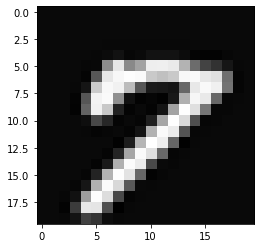

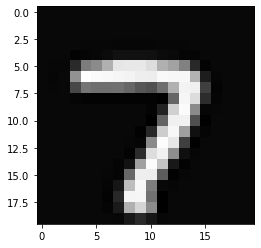

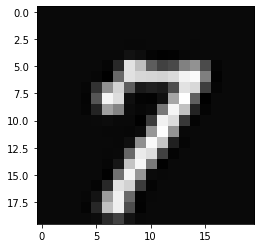

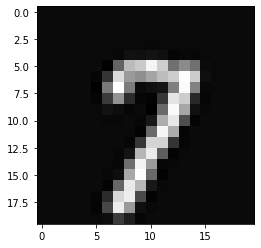

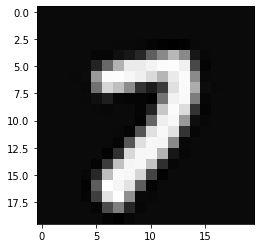

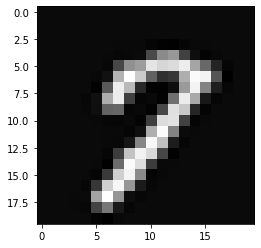

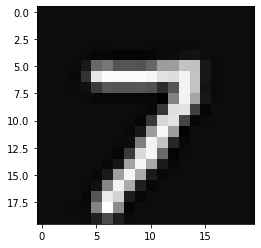

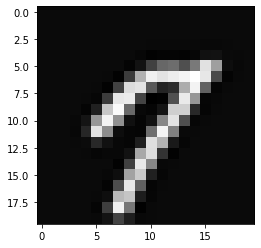

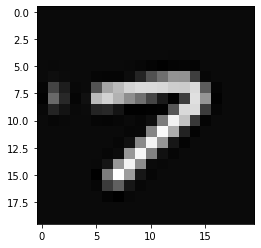

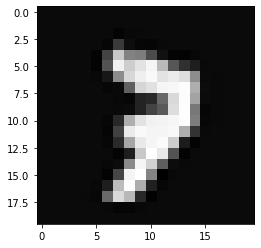

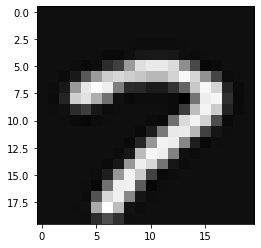

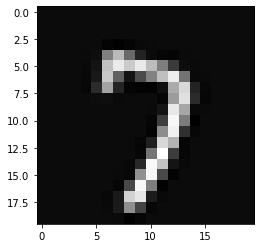

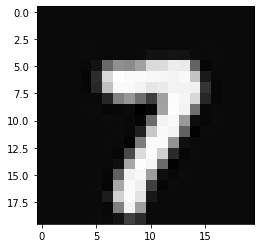

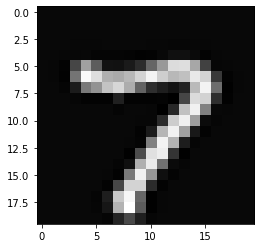

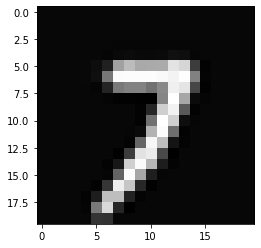

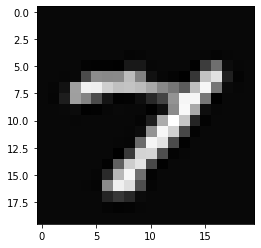

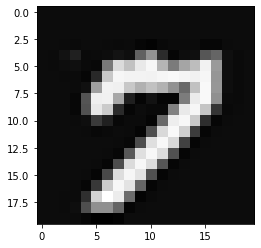

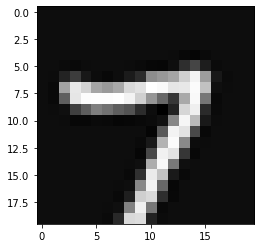

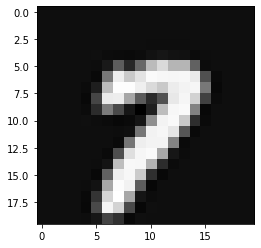

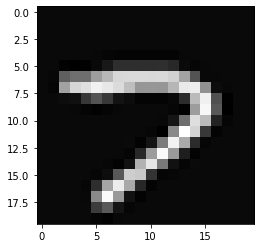

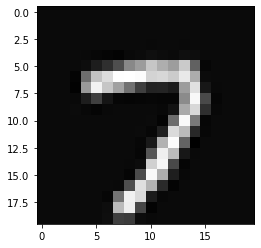

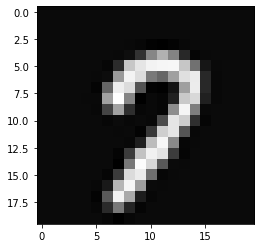

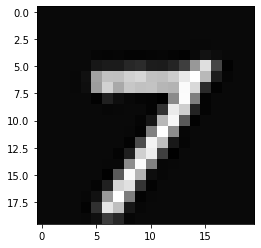

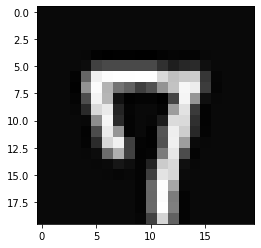

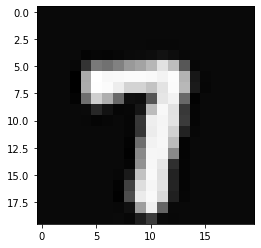

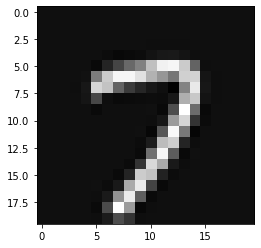

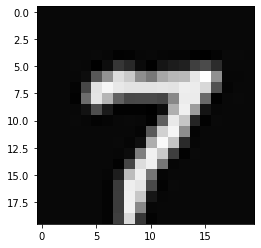

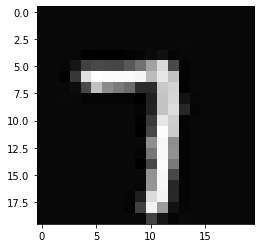

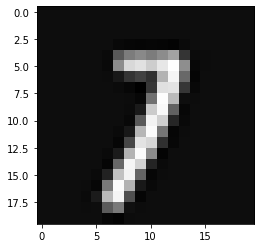

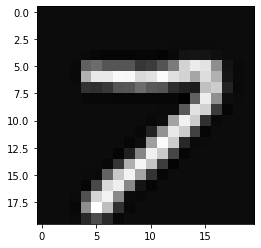

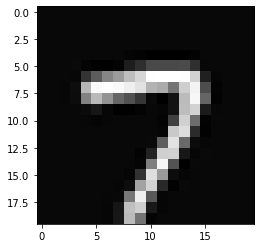

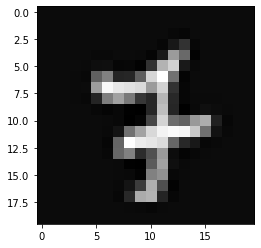

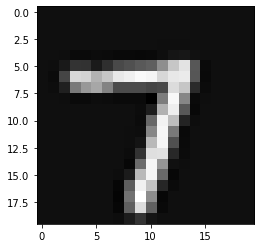

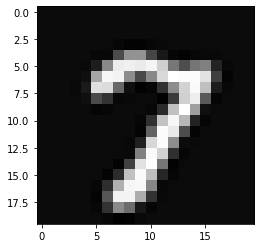

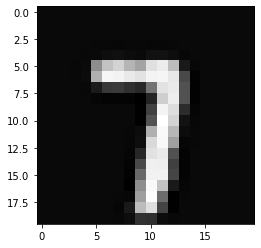

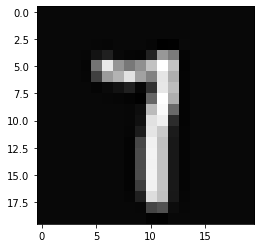

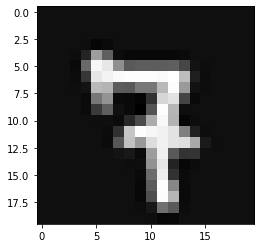

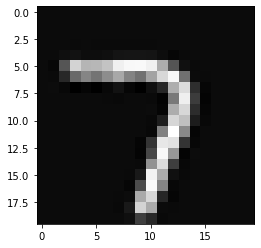

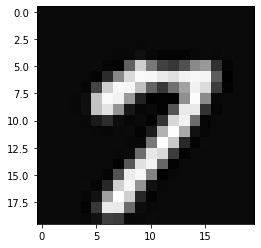

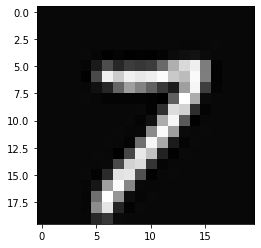

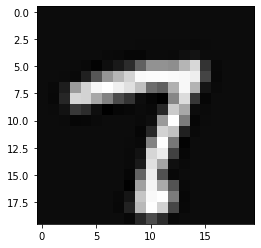

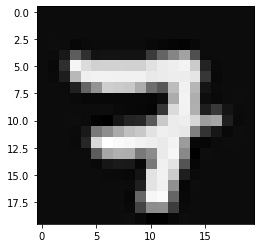

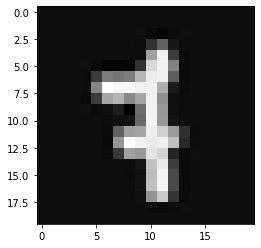

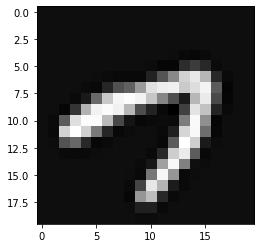

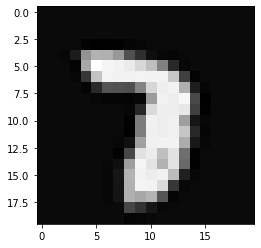

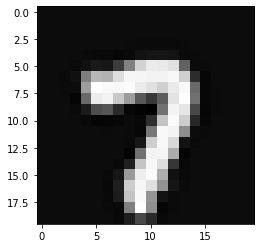

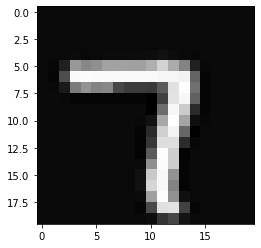

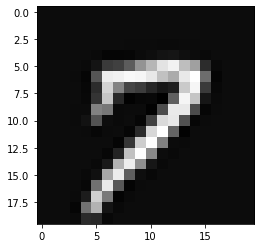

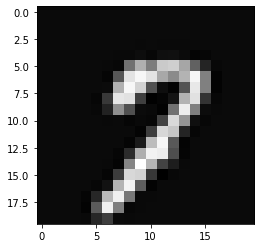

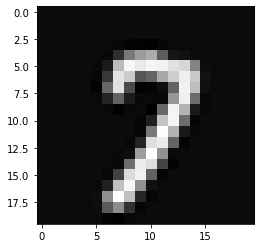

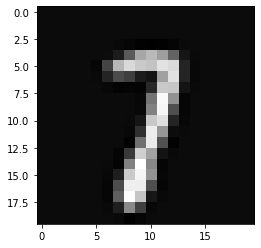

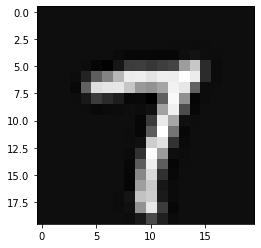

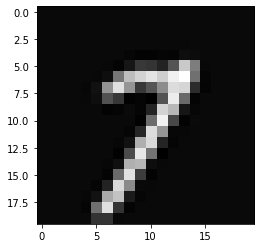

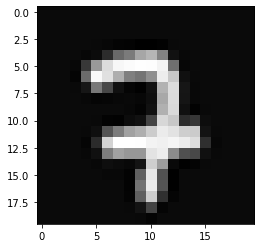

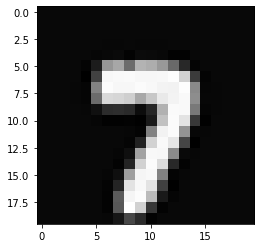

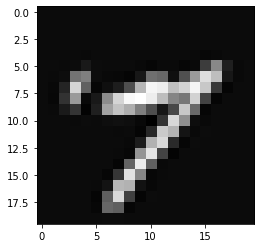

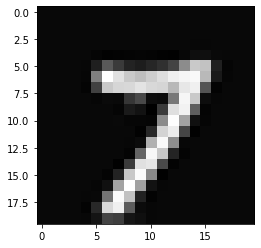

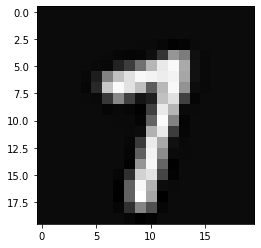

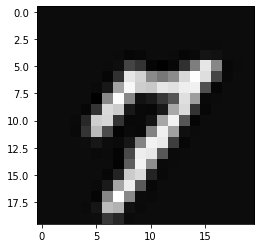

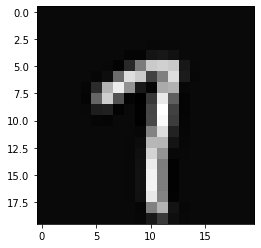

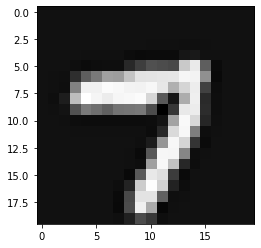

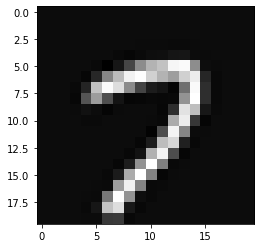

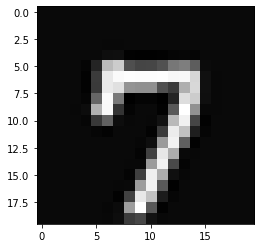

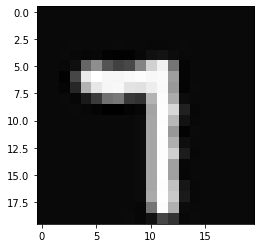

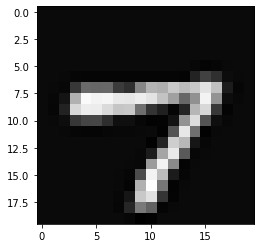

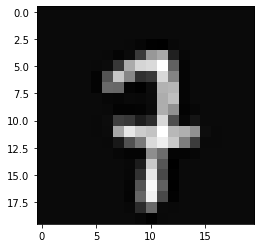

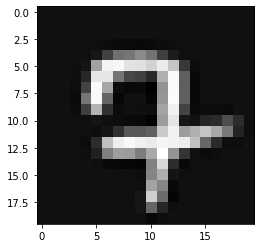

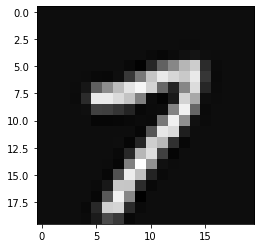

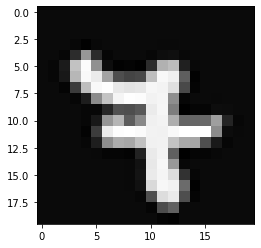

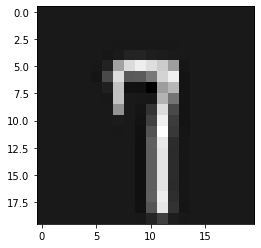

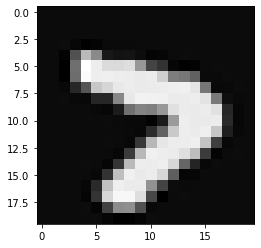

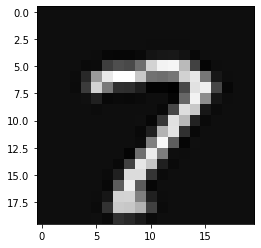

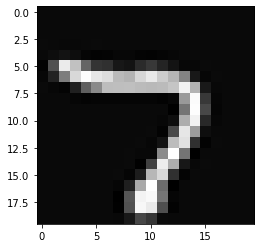

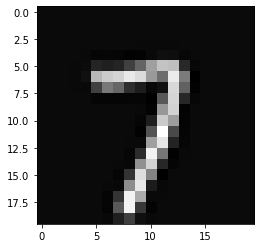

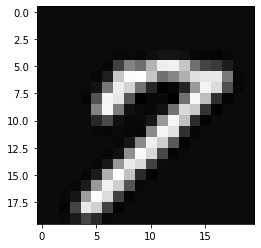

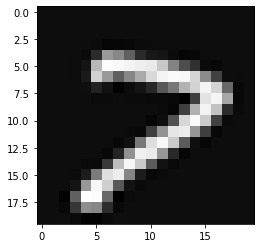

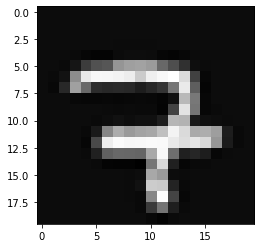

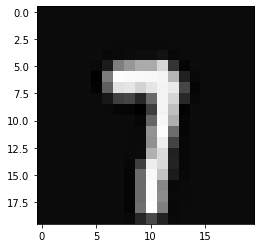

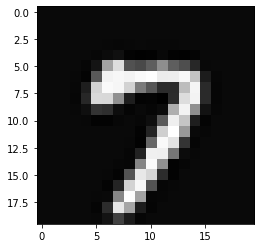

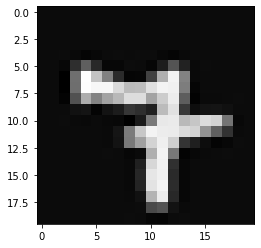

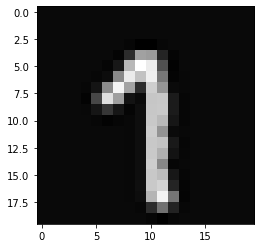

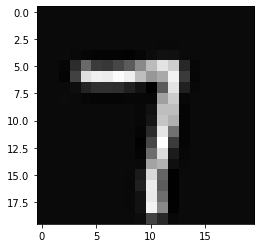

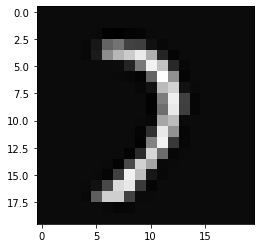

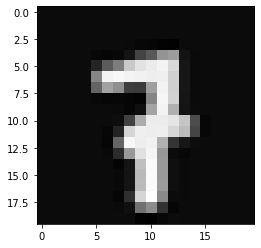

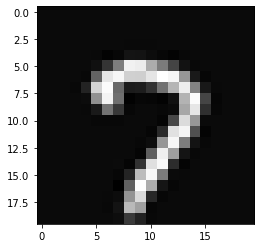

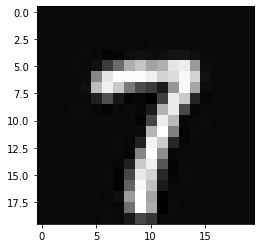

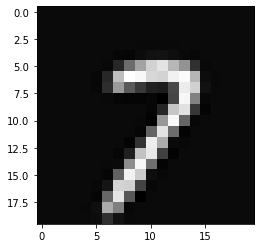

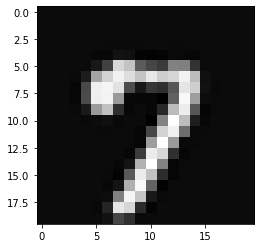

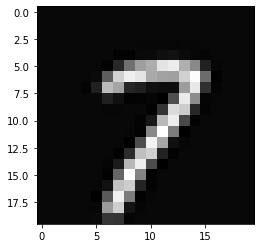

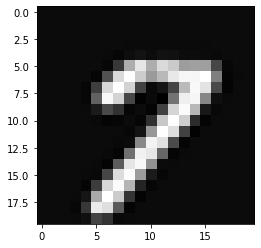

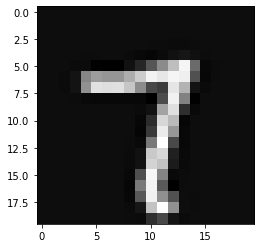

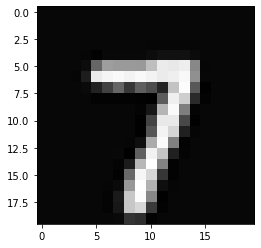

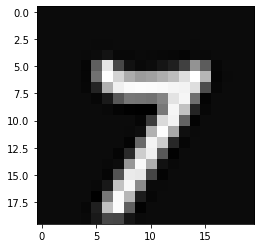

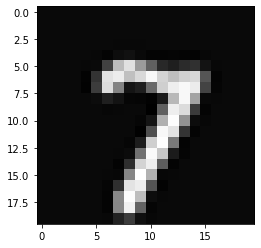

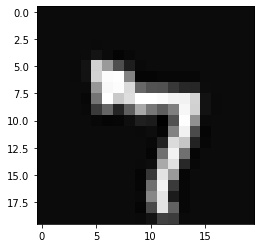

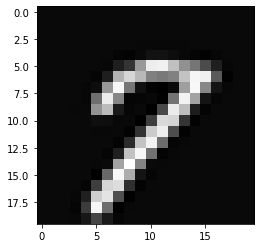

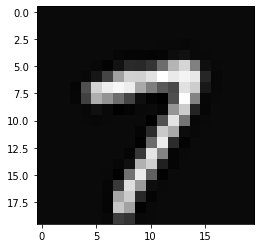

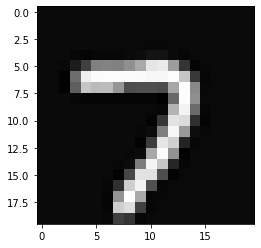

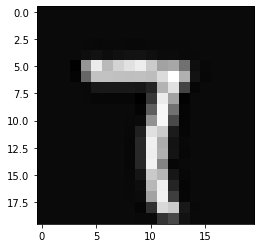

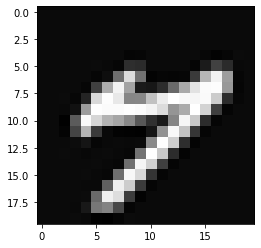

In [162]:
for ind in misclassified_index:
    plt.imshow(np.transpose(np.array(X_train.iloc[ind]).reshape(20, 20)), cmap=plt.get_cmap('gray'))
    plt.show()

It is the same problem with the test set.

<AxesSubplot:>

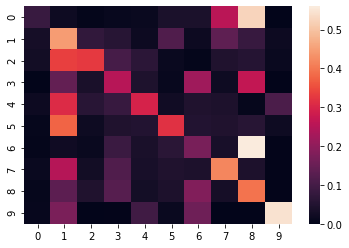

In [171]:
sns.heatmap(confusion_matrix_test)

In [169]:
misclassified_index = np.where((Y_test == 7) * (Y_test_pred == 9) == True)[0]

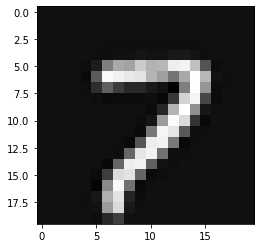

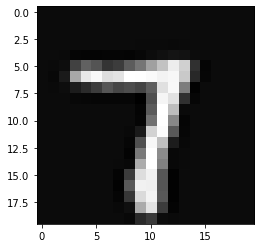

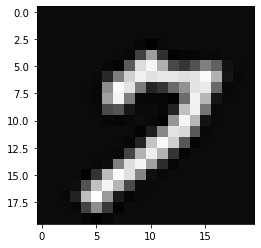

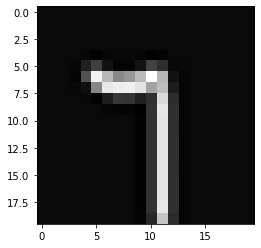

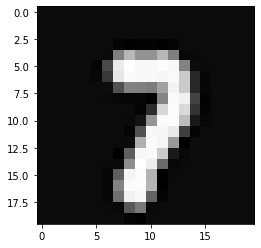

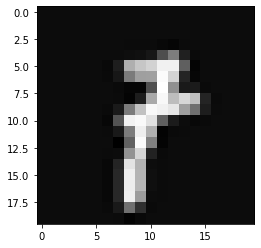

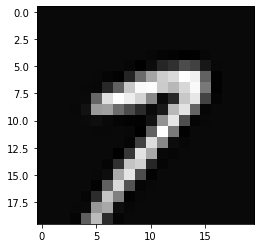

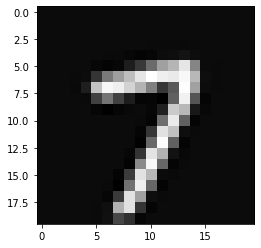

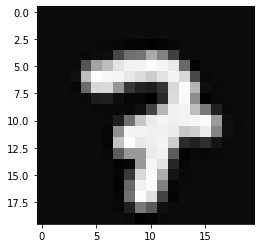

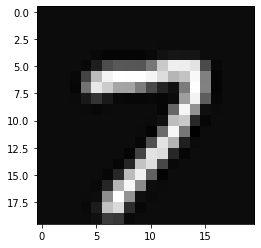

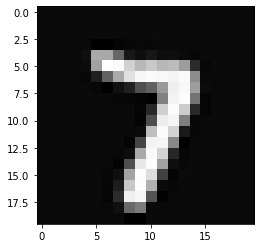

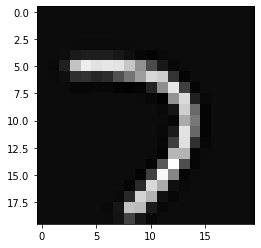

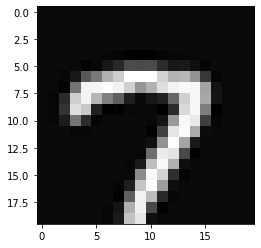

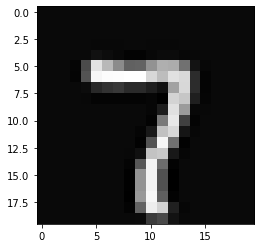

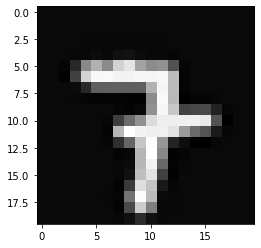

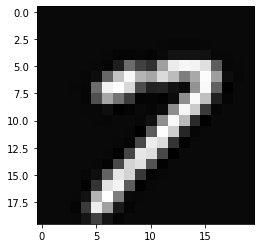

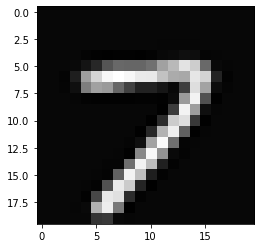

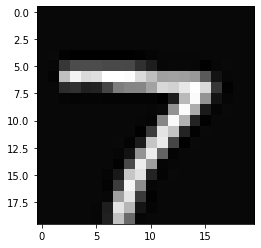

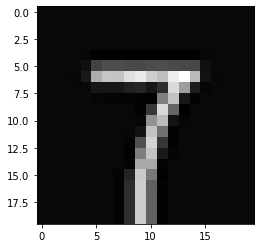

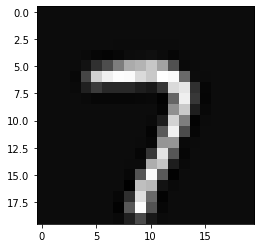

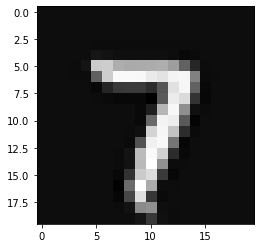

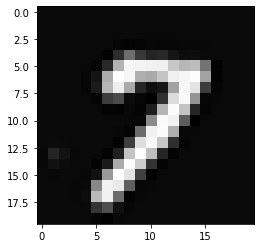

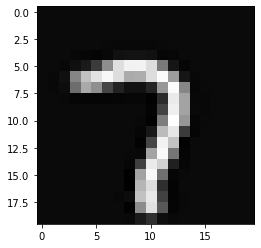

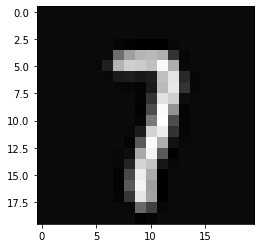

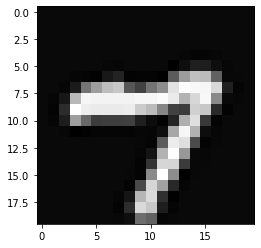

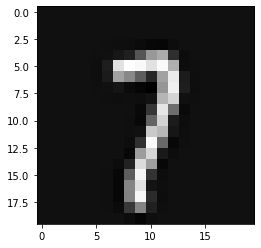

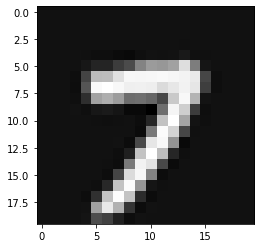

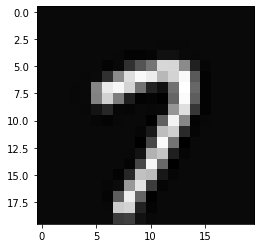

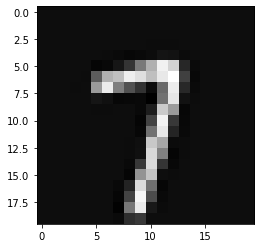

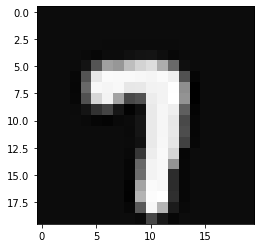

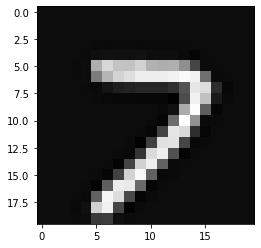

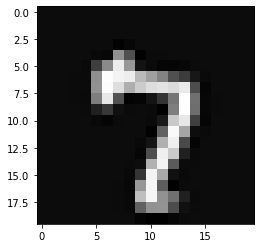

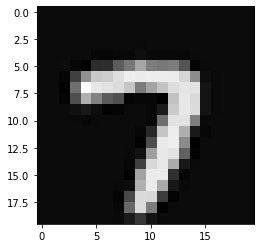

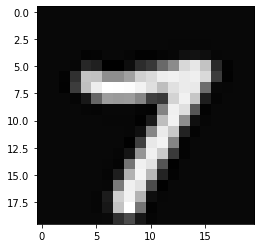

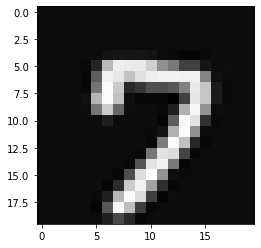

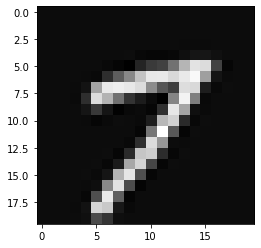

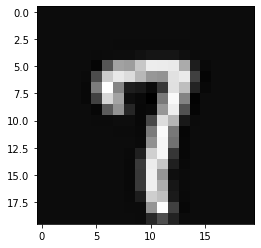

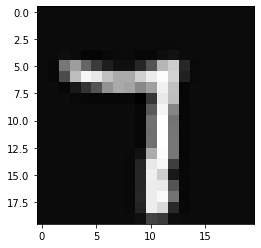

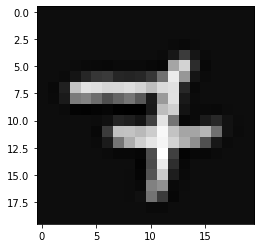

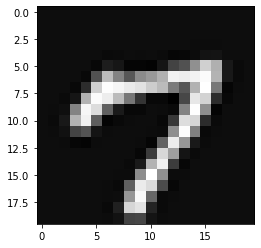

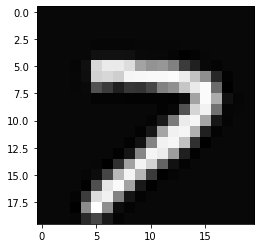

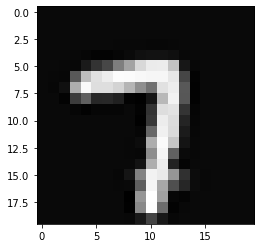

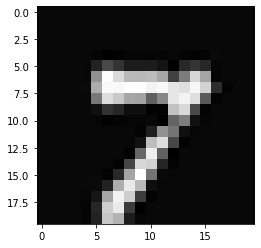

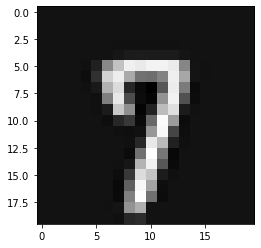

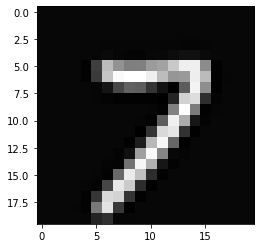

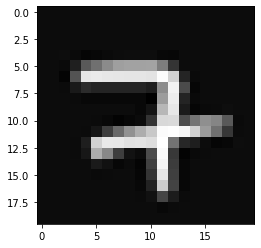

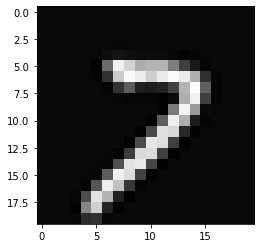

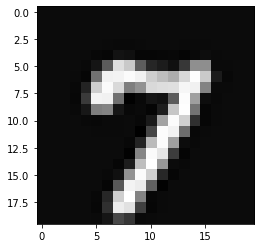

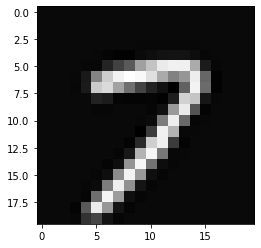

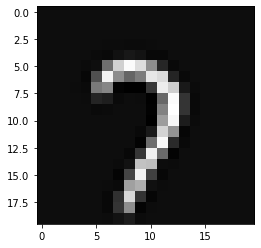

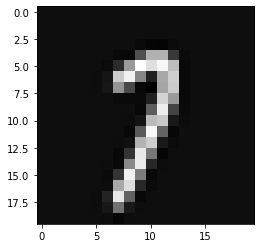

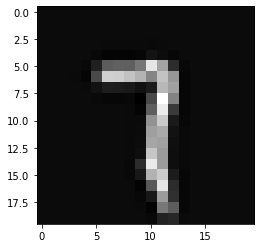

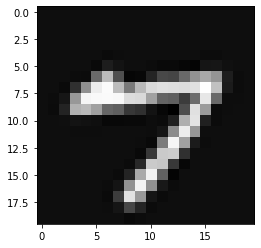

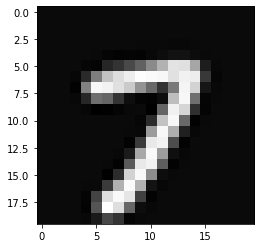

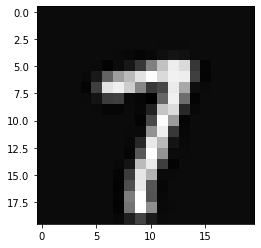

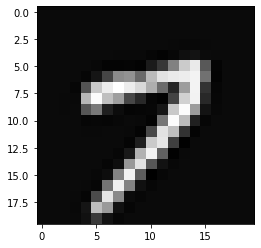

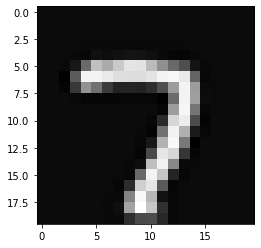

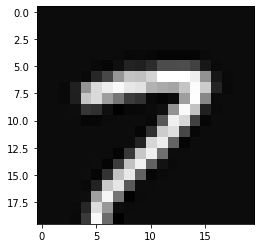

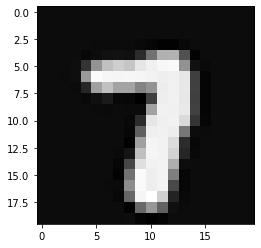

In [170]:
for ind in misclassified_index:
    plt.imshow(np.transpose(np.array(X_test.iloc[ind]).reshape(20, 20)), cmap=plt.get_cmap('gray'))
    plt.show()

# Principle component analysis

In [172]:
class PrincipleComponentAnalysis():
    def __init__(self):
        self.eig_val = None
        self.eig_vec = None
        self.k = None
        
    def fit(self, X):
        X = np.array(X)
        X_mean = np.mean(X, axis = 0)
        X_centered = X - X_mean
        X_cov = np.cov(np.transpose(X_centered))
        eig_val, eig_vec = np.linalg.eig(X_cov)
        plt.plot(eig_val)
        plt.show()
        
        self.eig_val = eig_val
        self.eig_vec = eig_vec
        
        return self
        
    def transform(self, X, k):
        X_proj = np.dot(np.transpose(self.eig_vec), np.transpose(X))
        X_best = np.transpose(X_proj[:k])
        self.k = k
        
        return X_best, self
        
    def fit_transform(self, X):
        X = np.array(X)
        X_mean = np.mean(X, axis = 0)
        X_centered = X - X_mean
        X_cov = np.cov(np.transpose(X_centered))
        eig_val, eig_vec = np.linalg.eig(X_cov)
        X_proj = np.dot(np.transpose(eig_vec), np.transpose(X_centered))
        X_best = np.transpose(X_proj[:self.k])
        
        return X_best

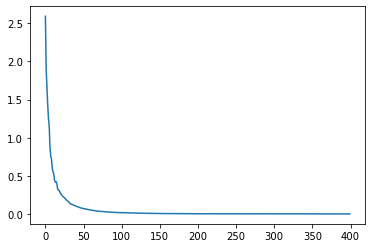

In [173]:
pca = PrincipleComponentAnalysis().fit(X_train)

In [174]:
X_train_pca = pca.transform(X_train, 50)[0]

In [175]:
X_test_pca = pca.fit_transform(X_test)

In [176]:
X_train_pca.shape

(4000, 50)

In [177]:
X_test_pca.shape

(1000, 50)

# Tune l1 penalty strength by cross validation using the dimensionally reduced dataset

In [178]:
import math

features_set = pd.DataFrame(X_train_pca)
group_set_transformed = pd.DataFrame(Y_train_transformed)
group_set = pd.DataFrame(Y_train)

n_train = X_train.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []

meshgrid = np.arange(0, 0.1, 0.01)

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold_transformed = group_set_transformed.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold_transformed = group_set_transformed.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        nn = NeuralNetwork().fit(features_set_train_fold, group_set_train_fold_transformed, alpha = 0.001, num_iterations = 100, input_no = 50, output_no = 10, lambda_ = lambda_)
        group_set_pred = nn.predict(features_set_fold)[1]
        total_error += np.sum(group_set_pred != np.array(group_set_fold))
        #total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.05


# Apply the neural network obtained to the dimensionally reduced train and test sets

In [179]:
nn = NeuralNetwork().fit(X_train_pca, Y_train_transformed, alpha = 0.001, num_iterations = 100, input_no = 50, output_no = 10, lambda_ = best_lambda)

In [180]:
# In sample error
Y_train_pred = nn.predict(X_train_pca)[1]
np.sum(Y_train_pred != np.array(Y_train))

3562

In [181]:
# Test error
Y_test_pred = nn.predict(X_test_pca)[1]
np.sum(nn.predict(X_test_pca)[1] != np.array(Y_test))

929

PCA does not improve prediction accuracy, but improves speed.

# PCA kernel

In [182]:
from sklearn.decomposition import KernelPCA

In [183]:
transformer = KernelPCA(n_components=50, kernel='rbf')
X_train_pca = transformer.fit_transform(X_train)
X_train_pca.shape

(4000, 50)

In [184]:
nn = NeuralNetwork().fit(X_train_pca, Y_train_transformed, alpha = 0.001, num_iterations = 100, input_no = 50, output_no = 10, lambda_ = best_lambda)

In [185]:
# Train error
Y_train_pred = nn.predict(X_train_pca)[1]
np.sum(Y_train_pred != np.array(Y_train))

2612

In [186]:
X_test_pca = transformer.transform(X_test)

In [187]:
# Test error
Y_test_pred = nn.predict(X_test_pca)[1]
np.sum(Y_test_pred != np.array(Y_test))

665

In our case, PCA with RBF kernel improves prediction accuracy over linear PCA.